In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
!unzip /content/drive/MyDrive/Covid19/Covid19-dataset/covid19.zip -d /content/covid19

Archive:  /content/drive/MyDrive/Covid19/Covid19-dataset/covid19.zip
replace /content/covid19/Covid19-dataset/test/Covid/0100.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [33]:
import os
os.listdir('/content/covid19')

['Covid19-dataset']

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [38]:
train_dir = '/content/drive/MyDrive/Covid19/Covid19-dataset/train'
test_dir = '/content/drive/MyDrive/Covid19/Covid19-dataset/test'

In [40]:
print(os.listdir('/content/drive/MyDrive/Covid19/Covid19-dataset/train'))


['Viral Pneumonia', 'Normal', 'Covid']


In [41]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Set validation split
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use subset for training
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use subset for validation
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


In [42]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [43]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20
)


Epoch 1/20
6/6 [==============================] - 57s 9s/step - loss: 1.1081 - accuracy: 0.4201 - val_loss: 1.0744 - val_accuracy: 0.3750
Epoch 2/20
6/6 [==============================] - 33s 5s/step - loss: 1.0359 - accuracy: 0.4675 - val_loss: 1.0226 - val_accuracy: 0.4688
Epoch 3/20
6/6 [==============================] - 36s 6s/step - loss: 1.0527 - accuracy: 0.4375 - val_loss: 0.9574 - val_accuracy: 0.5938
Epoch 4/20
6/6 [==============================] - 31s 5s/step - loss: 1.0368 - accuracy: 0.4911 - val_loss: 0.9187 - val_accuracy: 0.6562
Epoch 5/20
6/6 [==============================] - 31s 5s/step - loss: 0.9642 - accuracy: 0.5621 - val_loss: 0.9515 - val_accuracy: 0.6562
Epoch 6/20
6/6 [==============================] - 31s 5s/step - loss: 0.8968 - accuracy: 0.6095 - val_loss: 0.8680 - val_accuracy: 0.5312
Epoch 7/20
6/6 [==============================] - 31s 5s/step - loss: 0.8879 - accuracy: 0.6095 - val_loss: 0.8357 - val_accuracy: 0.7812
Epoch 8/20
6/6 [==================

In [44]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy}')

2/2 [==============================] - 4s 950ms/step - loss: 0.6949 - accuracy: 0.5800
Validation Accuracy: 0.5799999833106995


3/3 [==============================] - 9s 4s/step
                 precision    recall  f1-score   support

          Covid       1.00      0.81      0.89        26
         Normal       0.53      0.45      0.49        20
Viral Pneumonia       0.54      0.75      0.63        20

       accuracy                           0.68        66
      macro avg       0.69      0.67      0.67        66
   weighted avg       0.72      0.68      0.69        66



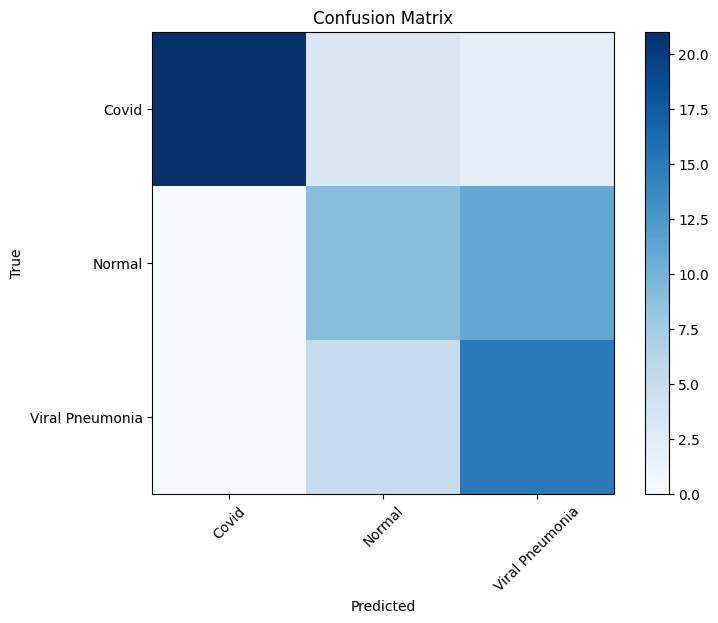

In [45]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Classification report and confusion matrix
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='none')
plt.colorbar()
plt.xticks(np.arange(3), test_generator.class_indices.keys(), rotation=45)
plt.yticks(np.arange(3), test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

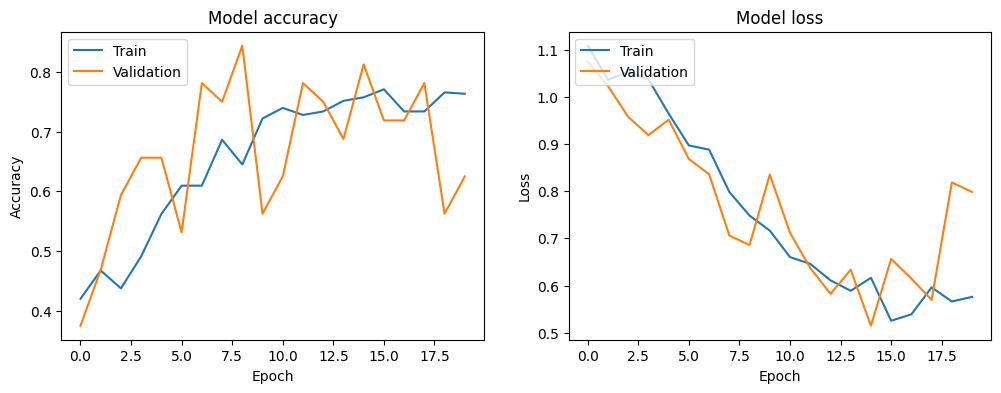

In [46]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()